In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Necessary Libraries

In [2]:
import os
import opendatasets as od
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mounting Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset into the notebook

In [4]:
data_path = '/content/drive/MyDrive/sign_data'

# Training Directory path
train_path = os.path.join(data_path,'train')
test_path = os.path.join(data_path,'test')

# Loading Training Data in the Generator (with Data Augmentation)
train_datagen = ImageDataGenerator (rescale = 1./255,
                                    
                                    # Changes in the height 
                                    height_shift_range = 0.4,

                                    #Changes in the width of the image
                                    width_shift_range = 0.4,

                                    # Shear Transformation
                                    shear_range = 0.3,

                                    # Zoom-in of the image
                                    zoom_range = 0.2,

                                    # Filling in the remaining pixels after 
                                    #transformation with the nearest pixel value
                                    fill_mode = 'nearest',

                                    # Rotation Angle
                                    rotation_range = 40,

                                    # Making sure that there is horizontal flip
                                    #in all the images
                                    horizontal_flip = True,
                                    
                                    #Vertical Flip
                                    vertical_flip  =True)

# Loading Test Data in the Generator
test_datagen = ImageDataGenerator(rescale = 1./255)

# Loading Data from Directory

In [5]:
# Loading Training Data from Training Generator
train_data = train_datagen.flow_from_directory(
              train_path,
              class_mode = 'binary',
              batch_size = 64,
              target_size = (224,224)    
)

# Loading Test Data from the Test Generator
test_data = test_datagen.flow_from_directory(
            test_path,
            class_mode = 'binary',
            target_size = (224,224),
            batch_size = 64
)

Found 1649 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


# Function to plot Training and Validation Graphs (Accuracy and Loss separately)

In [6]:
"""Function to plot model accuracy and loss"""

def model_plots(history):
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot  ( epochs,     acc )
  plt.plot  ( epochs, val_acc )
  plt.title ('Training and validation accuracy')
  plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'lower right')
  plt.figure()

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot  ( epochs,     loss )
  plt.plot  ( epochs, val_loss )
  plt.title ('Training and validation loss'   )
  plt.legend(['Training Loss','Validation Loss'], loc = 'upper left')
  plt.show()

# Visualizing Training Data Images

<Figure size 10800x10800 with 0 Axes>

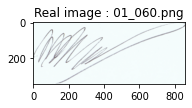

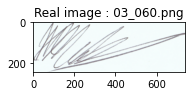

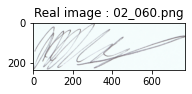

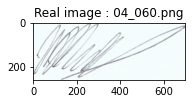

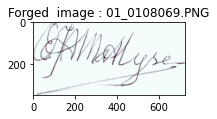

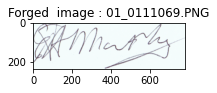

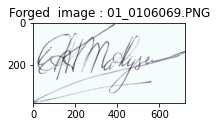

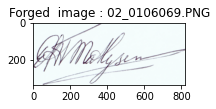

In [7]:
# Number of images to be displayed from each classs
num_images = 4

# Setting the size of the figure
fig = plt.gcf()
fig.set_size_inches(150,150)

# Gets the name of the directories that is the LABEL NAMES of the training images
train_directory_labels = os.listdir(train_path)

# Looping through the training label string names
for string_labels in train_directory_labels:

  # Labelling the type of images displayed
  #print(f"\nDisplaying {string_labels} images from Training Dataset\n")

  # Forming the path of the image
  image_path = os.path.join(train_path, string_labels)

  # Fetching name of the sub directories
  image_names = os.listdir(image_path)[0]

  # Making the full path of the folders
  image_path = os.path.join(image_path, image_names)

  # Finally, the names of the images
  image_names = os.listdir(image_path)

  # Index for the sub-plot
  index = 1

  for image_name in image_names[:num_images]:

    # Configuring the complete path of the individual image
    image = os.path.join(image_path,image_name)

    # Loading the image
    img = plt.imread(image)

    # Displaying Image
    plt.figure()
    plt.subplot(2,2,index)
    plt.imshow(img)

    # Updating index
    index += 1

    # Text of the title
    title_text = f"{string_labels} image : {image_name}"

    plt.title(title_text)

**CallBack to reduce the learning rate if the VALIDATION LOSS do not decrease for a certain number of epochs**

In [8]:
myCallback = callbacks.ReduceLROnPlateau(
             monitor = 'val_loss',
             patience = 2,
             factor = 0.02,
             lr = 1e-30
)

# CNN + Dense Layer Network

In [9]:
model = Sequential([
        #Adding convolutional layers
        Conv2D(16,(3,3) ,activation = 'relu', input_shape = (224,224,3)),
        MaxPooling2D (2,2),

        Conv2D(32,(3,3) , activation = 'relu'),
        MaxPooling2D (2,2),

        Conv2D(64,(3,3) , activation = 'relu'),
        MaxPooling2D (2,2),     

        Conv2D(128,(3,3) , activation = 'relu'),
        MaxPooling2D (2,2),  

        # Fully Connected Neural Network
        Flatten(),

        Dense(128, activation = 'relu'),
        Dense (64, activation = 'relu'),

        # Output Layer
        Dense(1, activation = 'sigmoid')
])

In [10]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

**Compiling and Training model**

In [11]:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'],
              optimizer = Adam(learning_rate = 0.001))

# Training model
history = model.fit(
          train_data,
          epochs = 40,
          validation_data = test_data,
          callbacks = [myCallback],
          verbose = 2
)

Epoch 1/40
26/26 - 675s - loss: 0.7273 - accuracy: 0.5252 - val_loss: 0.6929 - val_accuracy: 0.5040 - lr: 0.0010 - 675s/epoch - 26s/step
Epoch 2/40
26/26 - 27s - loss: 0.6917 - accuracy: 0.5318 - val_loss: 0.6923 - val_accuracy: 0.4960 - lr: 0.0010 - 27s/epoch - 1s/step
Epoch 3/40
26/26 - 28s - loss: 0.6929 - accuracy: 0.5240 - val_loss: 0.6957 - val_accuracy: 0.5040 - lr: 0.0010 - 28s/epoch - 1s/step
Epoch 4/40
26/26 - 28s - loss: 0.6915 - accuracy: 0.5294 - val_loss: 0.6926 - val_accuracy: 0.5040 - lr: 0.0010 - 28s/epoch - 1s/step
Epoch 5/40
26/26 - 26s - loss: 0.6918 - accuracy: 0.5379 - val_loss: 0.6929 - val_accuracy: 0.5040 - lr: 2.0000e-05 - 26s/epoch - 1s/step
Epoch 6/40
26/26 - 26s - loss: 0.6914 - accuracy: 0.5379 - val_loss: 0.6930 - val_accuracy: 0.5040 - lr: 2.0000e-05 - 26s/epoch - 1s/step
Epoch 7/40
26/26 - 26s - loss: 0.6912 - accuracy: 0.5379 - val_loss: 0.6930 - val_accuracy: 0.5040 - lr: 4.0000e-07 - 26s/epoch - 1s/step
Epoch 8/40
26/26 - 26s - loss: 0.6913 - accurac

# Plotting accuracy and Loss graphs

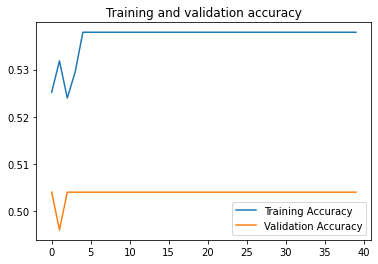

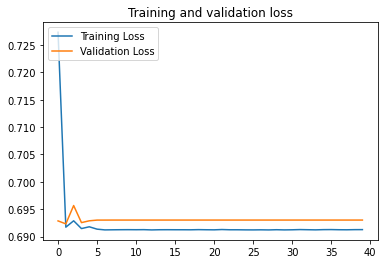

In [17]:
model_plots(history)

# Saving Model

In [16]:
model.save('drive/MyDrive/CNN_and_Dense_Network.h5')

# Configuring MobileNet for Transfer Learning

In [12]:
pre_trained_model = MobileNet(
                    include_top = False,
                    input_shape = (224,224,3),
                    weights = 'imagenet',
                    classes = 2
)

# Freezing the layers of the Pre-trained model
for layer in pre_trained_model.layers:
  layer.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [13]:
# Summary of the pre trained model
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

# Defining Model with Transfer Learning

In [14]:
# A sequential model
transfer_model = Sequential()

# Adding layers to the model
transfer_model.add(pre_trained_model)

# Flattening the layers
transfer_model.add(Flatten())

# Adding Fully Connected Layers
transfer_model.add(Dense(512, activation = 'relu'))
transfer_model.add(Dense(256, activation = 'relu'))

# Output Layer
transfer_model.add(Dense(1, activation = 'sigmoid'))

In [15]:
# Summary of the model
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               25690624  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 29,051,073
Trainable params: 25,822,209
Non-trainable params: 3,228,864
__________________________________

# Compiling and Training model

In [ ]:
# Compiling model
transfer_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'],
              optimizer = Adam(learning_rate = 0.001))

# Training Model
history = transfer_model.fit(
          train_data,
          epochs = 40,
          validation_data = test_data,
          callbacks = [myCallback],
          verbose = 2
)

Epoch 1/40
26/26 - 32s - loss: 3.8185 - accuracy: 0.5646 - val_loss: 0.9053 - val_accuracy: 0.6860 - lr: 0.0010 - 32s/epoch - 1s/step
Epoch 2/40
26/26 - 27s - loss: 0.6698 - accuracy: 0.7380 - val_loss: 0.4729 - val_accuracy: 0.7820 - lr: 0.0010 - 27s/epoch - 1s/step
Epoch 3/40
26/26 - 27s - loss: 0.5402 - accuracy: 0.7599 - val_loss: 0.3551 - val_accuracy: 0.8400 - lr: 0.0010 - 27s/epoch - 1s/step
Epoch 4/40
26/26 - 27s - loss: 0.5439 - accuracy: 0.7793 - val_loss: 0.4378 - val_accuracy: 0.8380 - lr: 0.0010 - 27s/epoch - 1s/step
Epoch 5/40
26/26 - 29s - loss: 0.5209 - accuracy: 0.7805 - val_loss: 0.2737 - val_accuracy: 0.8720 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 6/40
26/26 - 27s - loss: 0.3886 - accuracy: 0.8272 - val_loss: 0.2499 - val_accuracy: 0.8880 - lr: 0.0010 - 27s/epoch - 1s/step
Epoch 7/40
26/26 - 28s - loss: 0.3329 - accuracy: 0.8484 - val_loss: 0.4449 - val_accuracy: 0.7800 - lr: 0.0010 - 28s/epoch - 1s/step
Epoch 8/40
26/26 - 27s - loss: 0.4325 - accuracy: 0.8132 - val

# Plotting model graphs

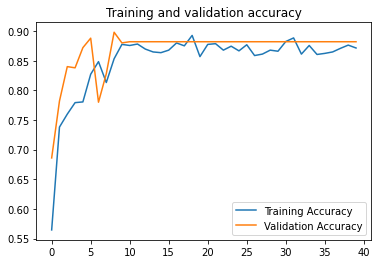

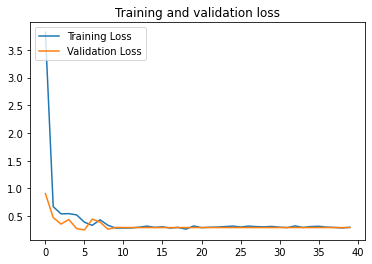

In [ ]:
model_plots(history)

# Saving model

In [ ]:
transfer_model.save('drive/MyDrive/Transfer_Learning_Signature.h5')